# Capstone Project

# Identifying Pneumonia by Chest X-Ray Images

I will build a convolutional neural network (CNN) to identify whether a patient has pneumonia or not by classifying their medical images. Recall shall be the success metric as there is a high risk associated with false negative classification when it comes to human diseases.

This project is adequately scoped and focuses on one specific type of disease rather than targeting multiple diagnosis. Therefore, there is a high chance to generate substentially accurate results.

Pneumonia is an infection that inflames lungs and can be diagnosed by radiologists who view the patient's chest x-rays. Creating an algorithm that provides accurate diagnosis can be beneficial for both patients and medical proffesionals.


## Data Guidelines

Source: https://data.mendeley.com/datasets/rscbjbr9sj/2  
Published: 6 Jan 2018 | Version 2 | DOI: 10.17632/rscbjbr9sj.2  
Contributor(s): Daniel Kermany, Kang Zhang, Michael Goldbaum

Kaggle link:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia  

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

**Train Dataset**

3883 .jpeg images labeled as PNEUMONIA (bacterial and viral).  
1349 .jpeg images labeled as NORMAL.

**Test Dataset**

390 .jpeg images labeled as PNEUMONIA (bacterial and viral).  
234 .jpeg images labeled as NORMAL.

# Part 1 - EDA and Data Exploration

This notebook will focus on exploring data, analyzing an plotting insightful stats (class balance, image size distribution, etc.), loading data as 3-dimensional array, and preprocess data to prepare for modeling.

### Imports

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from PIL import Image
import h5py

### Load the data

In [2]:
train_dir = './data/chest_xray/train/'
test_dir = './data/chest_xray/test/'
val_dir = './data/chest_xray/val/'

In [3]:
# Pneumonia images
p_images = glob(train_dir + '/PNEUMONIA/*.jpeg')

In [4]:
# Normal images
n_images = glob(train_dir + '/NORMAL/*.jpeg')

### EDA

Text(0.5, 1.0, 'Class Distribution')

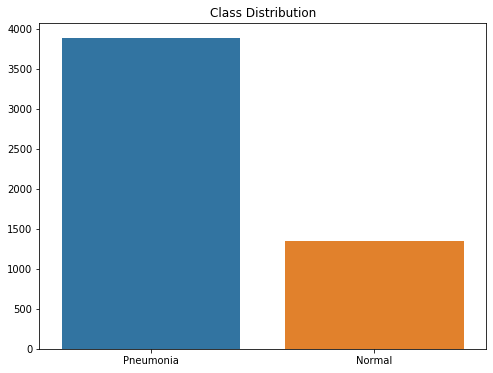

In [5]:
# Plot the class distribution
plt.figure(figsize=(8,6))
sns.barplot(['Pneumonia','Normal'],[len(p_images),len(n_images)])
plt.title('Class Distribution')

In [6]:
# Convert the first pneumonia image to array of pixels
np.asarray(plt.imread(p_images[0]))

array([[19, 19, 18, ...,  1,  0,  0],
       [19, 19, 18, ...,  1,  0,  0],
       [19, 19, 18, ...,  1,  0,  0],
       ...,
       [10, 10, 10, ..., 15, 15, 15],
       [10, 10, 10, ..., 15, 15, 15],
       [10, 10, 10, ..., 15, 15, 15]], dtype=uint8)

In [7]:
# Convert the first normal image to array of pixels
np.asarray(plt.imread(n_images[0]))

array([[ 22,  24,  24, ...,  96,  94,  93],
       [ 23,  24,  24, ...,  97,  94,  92],
       [ 24,  24,  23, ...,  99,  96,  94],
       ...,
       [ 49,  50,  48, ..., 119, 119, 119],
       [ 50,  52,  53, ..., 123, 124, 123],
       [ 52,  53,  54, ..., 129, 128, 127]], dtype=uint8)

In [8]:
# Check the shape of first pneumonia image array
np.asarray(plt.imread(p_images[0])).shape

(760, 1152)

In [9]:
# Check the shape of first normal image array
np.asarray(plt.imread(n_images[0])).shape

(1858, 2090)

In [10]:
img_class = []
height = []
weight = []

# Iterate through each image path
for d in os.listdir(train_dir):
        # find height and width of all train images
        for image in p_images:
                img_class.append(d)
                img_array = np.array(Image.open(image))
                height.append(img_array.shape[0])
                weight.append(img_array.shape[1])


# save image sizes to data frame
size_df = pd.DataFrame({
    'class': img_class,
    'height': height,
    'width': weight
})

Text(0.5, 1.0, 'Image Size Distribution')

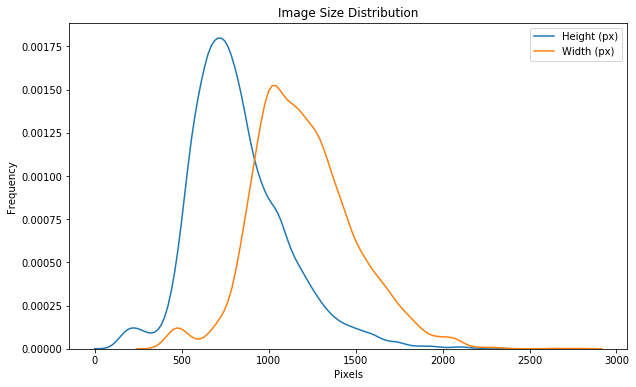

In [11]:
plt.figure(figsize = (10, 6))

sns.kdeplot(
    size_df['height'], label='Height (px)')
sns.kdeplot(
    size_df['width'], label='Width (px)')

plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')

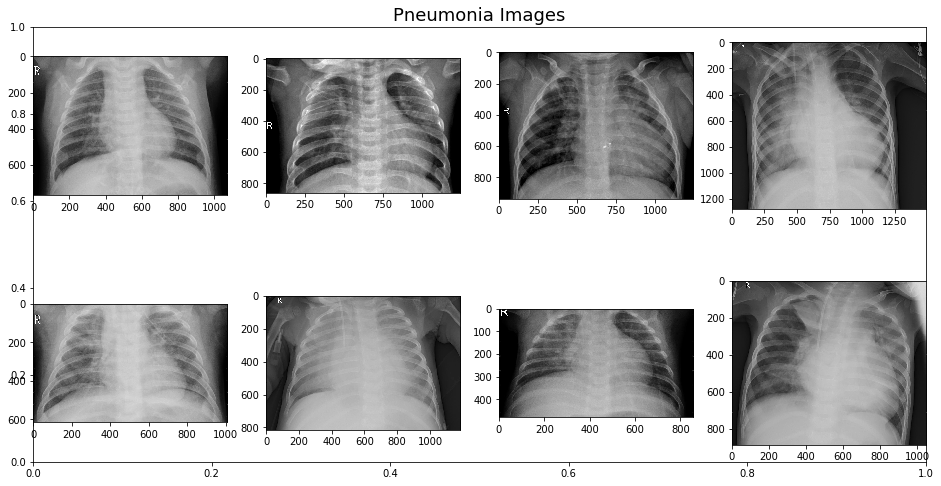

In [28]:
# Plot first eight images
fig=plt.figure(figsize=(16, 8))
plt.title('Pneumonia Images', fontsize=18)
cols = 4
rows = 2
for i in range(1, cols*rows +1):
    img = np.asarray(plt.imread(p_images[i]))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

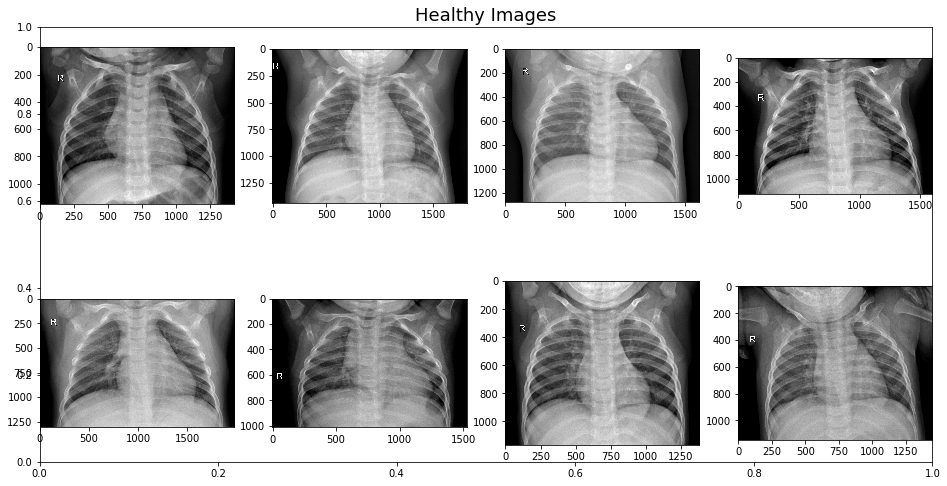

In [27]:
# Plot first eight images
fig=plt.figure(figsize=(16, 8))
plt.title('Healthy Images', fontsize=18)
cols = 4
rows = 2
for i in range(1, cols*rows +1):
    img = np.asarray(plt.imread(n_images[i]))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

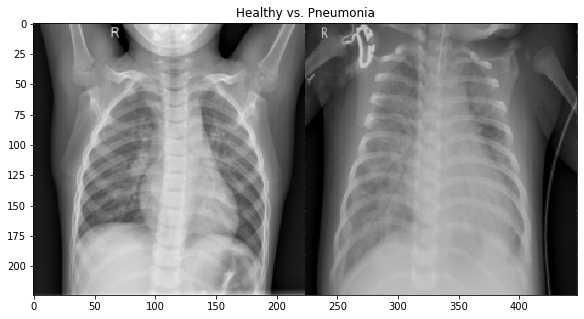

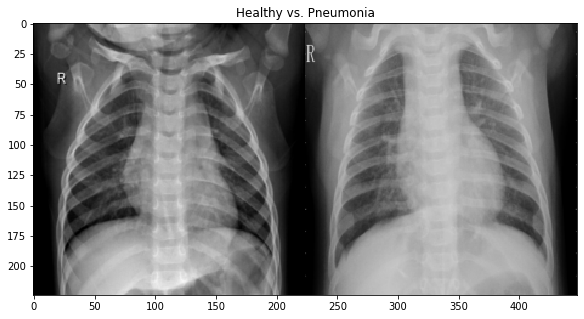

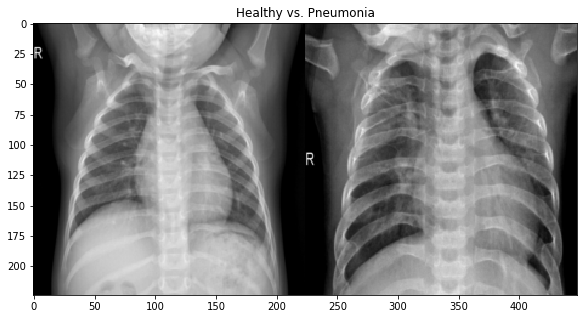

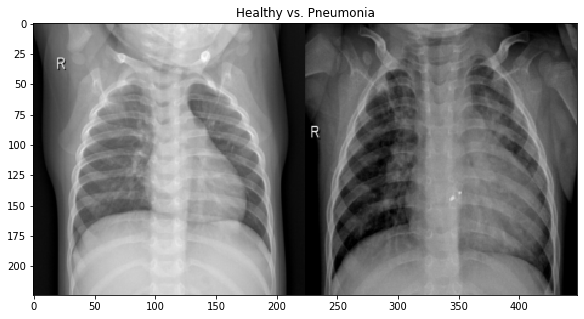

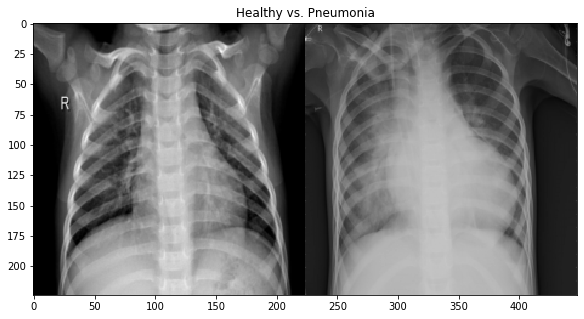

In [33]:
def pair_plot(index):
    n_image = skimage.transform.resize(cv2.imread(n_images[index]), (224, 224, 3))
    p_image = skimage.transform.resize(cv2.imread(p_images[index]), (224, 224, 3))
    pair = np.concatenate((n_image, p_image), axis=1)
    plt.figure(figsize=(10,8))
    plt.title("Healthy vs. Pneumonia")    
    plt.imshow(pair)
    plt.show()
    
for x in range(5):
    pair_plot(x)

### Data Preprocessing

In [14]:
train_images = glob(train_dir + '/NORMAL/*.jpeg') + glob(train_dir + '/PNEUMONIA/*.jpeg')

In [15]:
test_images = glob(test_dir + '/NORMAL/*.jpeg') + glob(test_dir + '/PNEUMONIA/*.jpeg')

In [16]:
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']


In [17]:
def load_data(dir_path):
    X = []
    y = []
    
    for dir_name in os.listdir(dir_path):
        if dir_name == 'NORMAL':
            label = 0
        elif dir_name == 'PNEUMONIA':
            label = 1
#         print(dir_name)
     
        image_paths = glob(dir_path + '/' + dir_name + '/*.jpeg')
        for image_file in image_paths:
#             print(f'image file: {image_file}')
            image = np.asarray(skimage.transform.resize(cv2.imread(image_file), (256, 256, 3)))
            X.append(image)
            y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [18]:
X_train, y_train = load_data(train_dir)

In [19]:
X_test, y_test = load_data(test_dir)

In [20]:
# Print size of train images and label arrays
print(f'Train size: {X_train.shape} \n {y_train.shape}')

Train size: (5232, 256, 256, 3) 
 (5232,)


In [21]:
# Print size of test images and label arrays
print(f'Test size: {X_test.shape} \n {y_test.shape}')

Test size: (494, 256, 256, 3) 
 (494,)


In [23]:
# Sanity check of first image array
X_train[0]

array([[[0.08627451, 0.08627451, 0.08627451],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.07058824, 0.07058824, 0.07058824],
        ...,
        [0.36862745, 0.36862745, 0.36862745],
        [0.36862745, 0.36862745, 0.36862745],
        [0.36862745, 0.36862745, 0.36862745]],

       [[0.08235294, 0.08235294, 0.08235294],
        [0.07881643, 0.07881643, 0.07881643],
        [0.07072449, 0.07072449, 0.07072449],
        ...,
        [0.36470588, 0.36470588, 0.36470588],
        [0.36862745, 0.36862745, 0.36862745],
        [0.36862745, 0.36862745, 0.36862745]],

       [[0.08627451, 0.08627451, 0.08627451],
        [0.08235294, 0.08235294, 0.08235294],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        ...,
        [0.36470588, 0.36470588, 0.36470588],
        [0.36470588, 0.36470588, 0.36470588],
        [0.36470588, 0.36470588, 0.36470588]],

       ...,

       [[0.11511949, 0.11511949, 0.11511949],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11119792, 0

In [24]:
y_train[0]

0

In [26]:
# Save train images as 3-dimensional array for further use in model
with h5py.File('train_dataset.h5', 'w') as hf:
    hf.create_dataset("train_images",  data=X_train)

In [ ]:
# Save test images as 3-dimensional array for further use in model
with h5py.File('test_dataset.h5', 'w') as hf:
    hf.create_dataset("test_images",  data=X_test)